In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import cv2
import os 
import utils

This notebook attempts to explore the data set through data analysis, preprocess the image and build input pipeline for model training

# Data Understanding 

In [2]:
df = pd.read_csv('Grade.csv')
print(df.head())

       name  patient ID  grade (GlaS)  grade (Sirinukunwattana et al. 2015)
0   testA_1           4        benign                           adenomatous
1  testA_10          10        benign                               healthy
2  testA_11           9        benign                               healthy
3  testA_12          11     malignant                 poorly differentiated
4  testA_13           7     malignant             moderately differentiated


In [3]:
print("Number of images: ", df.shape[0])

Number of images:  165


In [4]:
img_dir = 'glas_dataset/'
img_path = sorted((os.listdir(img_dir)))
print(img_path)

['testA_1.bmp', 'testA_10.bmp', 'testA_10_anno.bmp', 'testA_11.bmp', 'testA_11_anno.bmp', 'testA_12.bmp', 'testA_12_anno.bmp', 'testA_13.bmp', 'testA_13_anno.bmp', 'testA_14.bmp', 'testA_14_anno.bmp', 'testA_15.bmp', 'testA_15_anno.bmp', 'testA_16.bmp', 'testA_16_anno.bmp', 'testA_17.bmp', 'testA_17_anno.bmp', 'testA_18.bmp', 'testA_18_anno.bmp', 'testA_19.bmp', 'testA_19_anno.bmp', 'testA_1_anno.bmp', 'testA_2.bmp', 'testA_20.bmp', 'testA_20_anno.bmp', 'testA_21.bmp', 'testA_21_anno.bmp', 'testA_22.bmp', 'testA_22_anno.bmp', 'testA_23.bmp', 'testA_23_anno.bmp', 'testA_24.bmp', 'testA_24_anno.bmp', 'testA_25.bmp', 'testA_25_anno.bmp', 'testA_26.bmp', 'testA_26_anno.bmp', 'testA_27.bmp', 'testA_27_anno.bmp', 'testA_28.bmp', 'testA_28_anno.bmp', 'testA_29.bmp', 'testA_29_anno.bmp', 'testA_2_anno.bmp', 'testA_3.bmp', 'testA_30.bmp', 'testA_30_anno.bmp', 'testA_31.bmp', 'testA_31_anno.bmp', 'testA_32.bmp', 'testA_32_anno.bmp', 'testA_33.bmp', 'testA_33_anno.bmp', 'testA_34.bmp', 'testA_34_

From the data set directory above, we can observed that there is 3 main category, which is "train", "testA" and "testB", with each images in the category associated with one annotated file which is the pixel-wise annotation for segmentation  

Assign fold number to each image category for easy dataloading, such that:
- 'train' image => fold 0
- 'testA' image => fold 1
- 'testB' image => fold 2

In [5]:
fold = []
for name in df['name'].tolist():
    # split the name with '_' 
    candidate = name.split('_')
    # 'train' => 0
    if candidate[0] == 'train':
        fold.append(0)
    # 'testA' => 1
    if candidate[0] == 'testA':
        fold.append(1)
    # 'testB' => 2
    if candidate[0] == 'testB':
        fold.append(2)
df['fold'] = fold 
print(df)

         name  patient ID  grade (GlaS)  grade (Sirinukunwattana et al. 2015)  \
0     testA_1           4        benign                           adenomatous   
1    testA_10          10        benign                               healthy   
2    testA_11           9        benign                               healthy   
3    testA_12          11     malignant                 poorly differentiated   
4    testA_13           7     malignant             moderately differentiated   
..        ...         ...           ...                                   ...   
160  train_82           2     malignant    moderately-to-poorly differentated   
161  train_83          11     malignant                 poorly differentiated   
162  train_84          15        benign                               healthy   
163  train_85          10        benign                               healthy   
164   train_9          10        benign                               healthy   

     fold  
0       1  
1  

In [6]:
# image category index 
train_idx = np.where(df['fold'] == 0)[0]
testA_idx = np.where(df['fold'] == 1)[0]
testB_idx = np.where(df['fold'] == 2)[0]

### Distribution of Train and Test set 

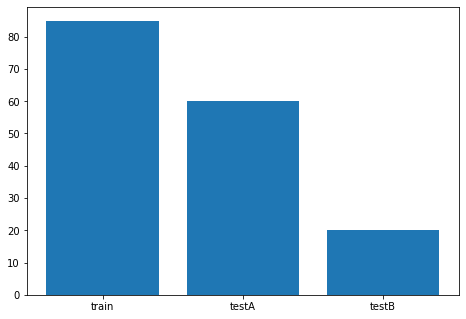

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fold = ['train', 'testA', 'testB']
n_img = [train_idx.shape[0], testA_idx.shape[0], testB_idx.shape[0]]
ax.bar(fold,n_img)
plt.show()

In [8]:
print('Number of train dataset:', train_idx.shape[0])
print('Number of testA dataset:', testA_idx.shape[0])
print('Number of testB dataset:', testB_idx.shape[0])

Number of train dataset: 85
Number of testA dataset: 60
Number of testB dataset: 20


### Distribution of Malignant and Benign class in train and test set

In [9]:
def unique_fn(x, idx):
    '''
    helper function to return the unique val counts 
    through index retrieval of the list
    '''
    return np.unique(np.take(x, idx), return_counts=True)

train_val, train_count = unique_fn(df[' grade (GlaS)'], train_idx)
testA_val, testA_count = unique_fn(df[' grade (GlaS)'], testA_idx)
testB_val, testB_count = unique_fn(df[' grade (GlaS)'], testB_idx)

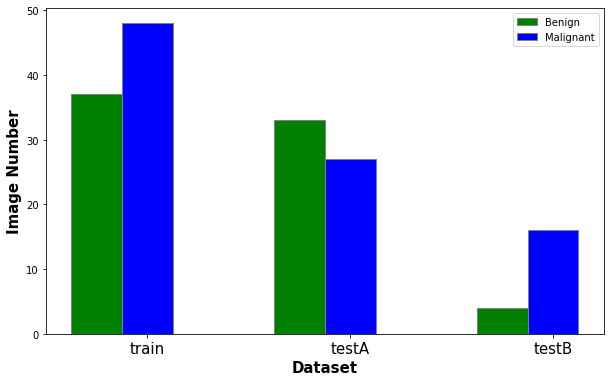

In [10]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(10, 6))
 
# set height of bar
data = np.stack([train_count, testA_count, testB_count]).T 
 
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, data[0], color ='g', width = barWidth,
        edgecolor ='grey', label ='Benign')
plt.bar(br2, data[1], color ='b', width = barWidth,
        edgecolor ='grey', label ='Malignant')
 
# Adding Xticks
plt.xlabel('Dataset', fontweight ='bold', fontsize = 15)
plt.ylabel('Image Number', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['train', 'testA', 'testB'], fontsize = 15)
 
plt.legend()
plt.show()

In [11]:
print('Train image, benign: {}, malignant: {}'.format(train_count[0], train_count[1]))
print('TestA image, benign: {}, malignant: {}'.format(testA_count[0], testA_count[1]))
print('TestB image, benign: {}, malignant: {}'.format(testB_count[0], testB_count[1]))

Train image, benign: 37, malignant: 48
TestA image, benign: 33, malignant: 27
TestB image, benign: 4, malignant: 16


### Image dataset width and height 

In [12]:
# add image width and height into the dataframe 
df['image_height'] = [cv2.imread(w).shape[0] for w in img_dir+df['name']+'.bmp']
df['image_width'] = [cv2.imread(w).shape[1] for w in img_dir+df['name']+'.bmp']

In [13]:
val, count = np.unique(df['image_width'], return_counts=True)
print('Image width: ', val)
print('Count: ', count)
print()
df['image_width'].describe()

Image width:  [567 574 578 581 589 775]
Count:  [  1   2   1   2   8 151]



count    165.000000
mean     758.739394
std       53.606959
min      567.000000
25%      775.000000
50%      775.000000
75%      775.000000
max      775.000000
Name: image_width, dtype: float64

In [14]:
val, count = np.unique(df['image_height'], return_counts=True)
print('Image height: ', val)
print('Count: ', count)
print()
df['image_height'].describe()

Image height:  [430 433 442 453 522]
Count:  [  1   3   2   8 151]



count    165.000000
mean     515.509091
std       21.550173
min      430.000000
25%      522.000000
50%      522.000000
75%      522.000000
max      522.000000
Name: image_height, dtype: float64

From the above analyses it is observed that the image size consisted of:
- Width range: 567~775   
- Height range: 430~522

However, most of the image falls under the size of (775x522)

### Image Pixel Check

In [15]:
# sample an image for checking 
tmp_img = cv2.imread(img_dir+'testA_1.bmp')
tmp_anno = cv2.imread(img_dir+'testA_1_anno.bmp')
print('Image Max pixel value: {}, Min pixel value: {}'.format(np.max(tmp_img), np.min(tmp_img)))
print('Image Max pixel value: {}, Min pixel value: {}'.format(np.max(tmp_anno), np.min(tmp_anno)))

Image Max pixel value: 255, Min pixel value: 16
Image Max pixel value: 9, Min pixel value: 0


The pixel value for the images falls between [0, 255] and for annotation images, we have gland wise labelling 

In [16]:
max_ = []
# find the maximum number of glands can an image have 
for name in img_path:
    # split the name with '_' 
    candidate = name.split('_')
    if candidate[-1] != 'anno.bmp':
        continue
    else:
        img_anno = cv2.imread(img_dir+name)
        max_.append(np.max(img_anno))
print("The maximum number of glands in an image is: ", np.max(max_))

The maximum number of glands in an image is:  32


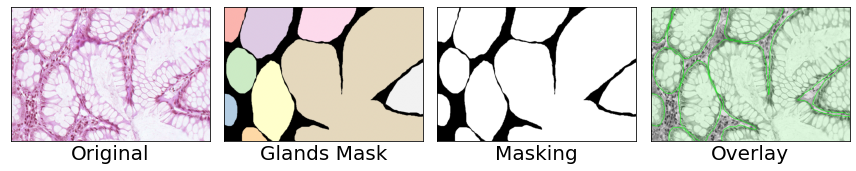

In [17]:
# cast annotated image segmentation to only foreground and background
tmp_anno_thres = np.where(tmp_anno>0, 1.0, 0.0)
# gland level masking
gland_mask = utils.plot_labels_color(tmp_anno, cmap='Pastel1')
# super imposed annotated image masking with boundary on glands
overlay_img = utils.overlay_boundary(utils.overlay_mask(tmp_img, tmp_anno_thres, alpha=0.1), 
                                     tmp_anno_thres)
imgs = [tmp_img, gland_mask, tmp_anno_thres, overlay_img]
captions = ['Original', 'Glands Mask', 'Masking', 'Overlay']
utils.plot_comparison(imgs, captions, n_col=len(imgs), 
                      figsize=(12,12), cmap=None)

# Data Preprocessing
In this section, the following process will be carried out:
- The images will be resize to (512, 512) with bilinear interpolation 
- All images will be stored in .npy format for better data-loading.  

Image normalization and annotated image binarization can be done on the fly

In [18]:
# intuitively resize to size with power of 2 for easier downsampling 
new_size = (512, 512)
# save directory  
save_dir = 'img_npy/'
img_save_path_list = []
anno_save_path_list = []
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for name in df['name']:
    gland_img = cv2.imread(img_dir+name+'.bmp').astype('float32')
    # resize image 
    gland_img = cv2.resize(gland_img, new_size)
    gland_img_save_path = save_dir+name+'.npy'
    np.save(gland_img_save_path, gland_img)
    img_save_path_list.append(gland_img_save_path)
    # -----------------------------------------
    gland_img_anno = cv2.imread(img_dir+name+'_anno.bmp').astype('float32')
    # resize anno
    gland_img_anno = cv2.resize(gland_img_anno, new_size)
    gland_img_anno_save_path = save_dir+name+'_anno.npy'
    np.save(gland_img_anno_save_path, gland_img_anno)
    anno_save_path_list.append(gland_img_anno_save_path)

In [19]:
# save .npy path list for image and image annotations into dataframe
df['img_npy'] = img_save_path_list
df['anno_npy'] = anno_save_path_list
print(df.head())

       name  patient ID  grade (GlaS)  grade (Sirinukunwattana et al. 2015)  \
0   testA_1           4        benign                           adenomatous   
1  testA_10          10        benign                               healthy   
2  testA_11           9        benign                               healthy   
3  testA_12          11     malignant                 poorly differentiated   
4  testA_13           7     malignant             moderately differentiated   

   fold  image_height  image_width               img_npy  \
0     1           522          775   img_npy/testA_1.npy   
1     1           522          775  img_npy/testA_10.npy   
2     1           522          775  img_npy/testA_11.npy   
3     1           522          775  img_npy/testA_12.npy   
4     1           522          775  img_npy/testA_13.npy   

                    anno_npy  
0   img_npy/testA_1_anno.npy  
1  img_npy/testA_10_anno.npy  
2  img_npy/testA_11_anno.npy  
3  img_npy/testA_12_anno.npy  
4  img_np

In [20]:
# save modified data frame into new csv file
df.to_csv('data.csv', index=False)
ds = pd.read_csv('data.csv')
print(ds)

         name  patient ID  grade (GlaS)  grade (Sirinukunwattana et al. 2015)  \
0     testA_1           4        benign                           adenomatous   
1    testA_10          10        benign                               healthy   
2    testA_11           9        benign                               healthy   
3    testA_12          11     malignant                 poorly differentiated   
4    testA_13           7     malignant             moderately differentiated   
..        ...         ...           ...                                   ...   
160  train_82           2     malignant    moderately-to-poorly differentated   
161  train_83          11     malignant                 poorly differentiated   
162  train_84          15        benign                               healthy   
163  train_85          10        benign                               healthy   
164   train_9          10        benign                               healthy   

     fold  image_height  im